# L2HMC with MOG target distrubtion using eager execution in tensorflow

### Imports

In [1]:
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from l2hmc_eager import dynamics_eager as l2hmc
from l2hmc_eager.neural_nets import *
from utils.distributions import GMM, gen_ring
from utils.jacobian import _map, jacobian

%autoreload 2

Using TensorFlow backend.


In [2]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [3]:
tfe = tf.contrib.eager

In [3]:
def train_one_iter(dynamics, x, optimizer, 
                   loss_fn=l2hmc.compute_loss, global_step=None):
    loss, grads, out, accept_prob = l2hmc.loss_and_grads(
        dynamics, x, loss_fn=loss_fn
    )
    optimizer.apply_gradients(
        zip(grads, dynamics.trainable_variables), global_step=global_step
    )
    return loss, out, accept_prob

In [4]:
def distribution_arr(x_dim, n_distributions):
    """Create array describing likelihood of drawing from distributions."""
    if n_distributions > x_dim:
        pis = [1. / n_distributions] * n_distributions
        pis[0] += 1 - sum(pis)
        return np.array(pis)
    if x_dim == n_distributions:
        big_pi = round(1.0 / n_distributions, x_dim)
        pis = n_distributions * [big_pi]
        return np.array(pis)
    else:
        big_pi = (1.0 / n_distributions) - x_dim * 1E-16
        pis = n_distributions * [big_pi]
        small_pi = (1. - sum(pis)) / (x_dim - n_distributions)
        pis.extend((x_dim - n_distributions) * [small_pi])
        return np.array(pis)

### MoG Model

In [5]:
x_dim = 2 
num_distributions = 2
sigma = 0.05
axis = 0
centers = 1

means = np.zeros((x_dim, x_dim))
means[::2, axis] = centers
means[1::2, axis] = - centers

cov_mtx = sigma * np.eye(x_dim)
sigmas = np.array([cov_mtx] * x_dim)

pis = distribution_arr(x_dim, num_distributions)
mog_distribution = GMM(means, sigmas, pis)

In [6]:
mog_potential_fn = mog_distribution.get_energy_function()

mog_dynamics = l2hmc.Dynamics(x_dim=2, 
                              minus_loglikelihood_fn=mog_potential_fn,
                              n_steps=2,
                              eps=0.5,
                              np_seed=1)

In [25]:
train_iters = 1000
eval_iters = 20 
n_samples = 200
record_loss_every = 10 
save_steps = 100 

global_step = tf.train.get_or_create_global_step()
global_step.assign(1)
learning_rate = tf.train.exponential_decay(1e-3, global_step, 
                                           1000, 0.96, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate)
checkpointer = tf.train.Checkpoint(optimizer=optimizer,
                                   dynamics=mog_dynamics,
                                   global_step=global_step)

log_dir = '../../tf_eager_log/mog_model/run_3/'
summary_writer = tf.contrib.summary.create_file_writer(log_dir)
# if restore:
#     latest_path = tf.train.latest_checkpoint(train_dir)
#     checkpointer.restore(latest_path)
#     print("Restored latest checkpoint at path:\"{}\"".format(latest_path))
#     sys.stdout.flush()
# if not restore:
#     if use_defun:
#         loss_fn = tfe.function(l2hmc.compute_loss)
#     else:
loss_fn = tfe.defun(l2hmc.compute_loss)
samples = tf.random_normal(shape=[n_samples, x_dim])
for i in range(1, train_iters + 1):
    loss, samples, accept_prob = train_one_iter(
        mog_dynamics,
        samples,
        optimizer,
        loss_fn=loss_fn,
        global_step=global_step
    )
    
    if i % record_loss_every == 0:
        print("Iteration {}, loss {:.4f}, x_accept_prob {:.4f}".format(
            i, loss.numpy(), accept_prob.numpy().mean()
        ))
        with summary_writer.as_default():
            with tf.contrib.summary.always_record_summaries():
                _ = tf.contrib.summary.scalar("Training loss", 
                                              loss, 
                                              step=global_step)
                
    if i % save_steps == 0:
        saved_path = checkpointer.save(file_prefix=os.path.join(log_dir,
                                                                "ckpt"))
        print(f"Saved checkpoint to: {saved_path}")
        
print("Training complete.")
sys.stdout.flush()

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

Iteration 10, loss -47.2614, x_accept_prob 0.7577
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 20, loss -30.4775, x_accept_prob 0.7110
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 30, loss -35.3669, x_accept_prob 0.6844
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 40, loss -34.1057, x_accept_prob 0.7051
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 50, loss -43.2409, x_accept_prob 0.7326
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 60, loss -42.7054, x_accept_prob 0.7475
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 70, loss -40.2206, x_accept_prob 0.7454
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 80, loss -38.5606, x_accept_prob 0.7302
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 90, loss -32.3944, x_accept_prob 0.7163
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 100, loss -37.5129, x_accept_prob 0.7309
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 110, loss -37.5030, x_accept_prob 0.7504
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 120, loss -49.5894, x_accept_prob 0.7333
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 130, loss -43.3390, x_accept_prob 0.6920
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 140, loss -35.3204, x_accept_prob 0.7165
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 150, loss -41.7768, x_accept_prob 0.6851
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 160, loss -41.8420, x_accept_prob 0.7232
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 170, loss -36.1308, x_accept_prob 0.6592
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 180, loss -36.4720, x_accept_prob 0.6539
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 190, loss -45.1031, x_accept_prob 0.7126
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 200, loss -50.0267, x_accept_prob 0.7562
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 210, loss -46.4964, x_accept_prob 0.7672
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 220, loss -45.0975, x_accept_prob 0.7623
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 230, loss -45.4271, x_accept_prob 0.7933
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 240, loss -34.3553, x_accept_prob 0.7453
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 250, loss -47.2870, x_accept_prob 0.7297
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 260, loss -40.9772, x_accept_prob 0.7299
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 270, loss -47.9160, x_accept_prob 0.7190
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 280, loss -45.0080, x_accept_prob 0.7298
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 290, loss -43.6011, x_accept_prob 0.7392
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 300, loss -46.9600, x_accept_prob 0.7389
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 310, loss -43.1433, x_accept_prob 0.7526
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 320, loss -39.2730, x_accept_prob 0.7868
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 330, loss -44.1910, x_accept_prob 0.7630
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 340, loss -39.9064, x_accept_prob 0.7374
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 350, loss -35.9237, x_accept_prob 0.7209
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 360, loss -38.6184, x_accept_prob 0.7562
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 370, loss -37.6100, x_accept_prob 0.7431
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 380, loss -39.7404, x_accept_prob 0.7605
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 390, loss -45.8837, x_accept_prob 0.7629
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 400, loss -45.6134, x_accept_prob 0.7934
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 410, loss -38.6547, x_accept_prob 0.7784
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 420, loss -42.4311, x_accept_prob 0.7258
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 430, loss -41.9248, x_accept_prob 0.7494
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 440, loss -47.0396, x_accept_prob 0.7999
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 450, loss -40.7162, x_accept_prob 0.7428
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 460, loss -44.0749, x_accept_prob 0.7625
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 470, loss -48.0625, x_accept_prob 0.7675
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 480, loss -46.3806, x_accept_prob 0.7791
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 490, loss -48.7545, x_accept_prob 0.7470
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 500, loss -52.5057, x_accept_prob 0.7798
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Saved checkpoint to: ../../tf_eager_log/mog_model/run_2/ckpt-1
Iteration 510, loss -39.5860, x_accept_prob 0.7323
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 520, loss -43.6680, x_accept_prob 0.7716
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 530, loss -42.4036, x_accept_prob 0.7752
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 540, loss -53.9451, x_accept_prob 0.7918
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 550, loss -40.8895, x_accept_prob 0.7877
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 560, loss -44.8358, x_accept_prob 0.8119
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 570, loss -49.0909, x_accept_prob 0.8160
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 580, loss -46.7551, x_accept_prob 0.7681
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 590, loss -46.8780, x_accept_prob 0.8080
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 600, loss -41.5492, x_accept_prob 0.7925
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 610, loss -43.6870, x_accept_prob 0.7642
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 620, loss -40.6354, x_accept_prob 0.7884
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 630, loss -45.5121, x_accept_prob 0.7651
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 640, loss -45.2031, x_accept_prob 0.8036
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 650, loss -42.8566, x_accept_prob 0.7483
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 660, loss -48.8829, x_accept_prob 0.7826
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 670, loss -45.5735, x_accept_prob 0.8140
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 680, loss -46.3693, x_accept_prob 0.7845
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 690, loss -48.7234, x_accept_prob 0.8029
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 700, loss -49.3126, x_accept_prob 0.8242
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 710, loss -52.5303, x_accept_prob 0.8114
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 720, loss -45.3288, x_accept_prob 0.7944
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 730, loss -49.3423, x_accept_prob 0.7473
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 740, loss -44.3362, x_accept_prob 0.7935
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 750, loss -52.3376, x_accept_prob 0.7834
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 760, loss -47.0273, x_accept_prob 0.7744
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 770, loss -49.3517, x_accept_prob 0.8058
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 780, loss -41.5394, x_accept_prob 0.7810
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 790, loss -50.7021, x_accept_prob 0.7815
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 800, loss -42.1356, x_accept_prob 0.7700
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 810, loss -47.6812, x_accept_prob 0.7659
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 820, loss -50.0707, x_accept_prob 0.7949
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 830, loss -48.0332, x_accept_prob 0.7768
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 840, loss -47.5684, x_accept_prob 0.7606
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 850, loss -33.7760, x_accept_prob 0.8011
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 860, loss -44.3587, x_accept_prob 0.8133
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 870, loss -42.3892, x_accept_prob 0.8087
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 880, loss -41.9609, x_accept_prob 0.8151
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 890, loss -45.5040, x_accept_prob 0.8093
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 900, loss -43.2053, x_accept_prob 0.7729
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 910, loss -38.3361, x_accept_prob 0.7714
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 920, loss -40.0306, x_accept_prob 0.7839
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 930, loss -48.3043, x_accept_prob 0.7768
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 940, loss -38.5376, x_accept_prob 0.7755
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 950, loss -38.1938, x_accept_prob 0.7580
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 960, loss -58.2166, x_accept_prob 0.7688
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 970, loss -39.7796, x_accept_prob 0.7676
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 980, loss -42.3282, x_accept_prob 0.7366
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 990, loss -47.3547, x_accept_prob 0.7606
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Iteration 1000, loss -48.6920, x_accept_prob 0.7751
INFO:tensorflow:Summary name Training loss is illegal; using Training_loss instead.


<tf.Tensor: id=4559641, shape=(), dtype=bool, numpy=True>

Saved checkpoint to: ../../tf_eager_log/mog_model/run_2/ckpt-2
Training complete.


In [32]:
_samples = tf.random_normal(shape=[n_samples, x_dim])
samples_history = []
for i in range(100):
    samples_history.append(_samples.numpy())
    _, _, _, _samples = mog_dynamics.apply_transition(_samples)
samples_history = np.array(samples_history)

In [33]:
samples_history.shape

(100, 200, 2)

In [37]:
target_samples

array([[-9.34409537e-01,  6.77086193e-02],
       [-1.33721625e+00, -6.14493006e-02],
       [ 1.16848279e+00,  1.77252185e-01],
       [ 9.84313456e-01, -3.61864328e-02],
       [ 9.73416075e-01, -3.80562308e-01],
       [-5.18297827e-01, -2.44713976e-01],
       [ 4.77247693e-01, -8.77689350e-02],
       [ 7.74380509e-01,  3.99639495e-02],
       [-8.22231500e-01, -1.53768545e-01],
       [ 1.38401779e+00, -1.19056258e-01],
       [-8.48990934e-01, -1.31103921e-01],
       [-1.14306018e+00,  1.53626380e-01],
       [ 1.21602837e+00,  3.89105809e-01],
       [-9.59662833e-01,  5.83784887e-03],
       [-1.04197418e+00, -1.87062047e-01],
       [ 8.43334600e-01, -3.55953149e-01],
       [ 1.00692753e+00,  2.05514506e-01],
       [ 1.19058155e+00, -5.04949551e-01],
       [-1.17915120e+00,  2.80578293e-01],
       [ 1.13758580e+00, -2.33053579e-01],
       [ 7.87667115e-01, -1.94596995e-01],
       [ 1.76169709e+00, -3.36935350e-01],
       [-7.68604225e-01,  1.62959244e-01],
       [-6.

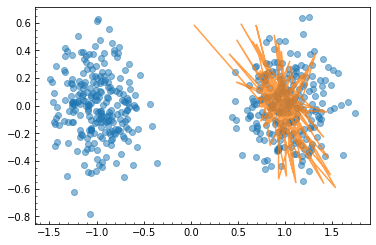

In [44]:
target_samples = mog_distribution.get_samples(500)
fig, ax = plt.subplots()
ax.plot(target_samples[:,0], target_samples[:,1], color='C0', alpha=0.5, marker='o', ls='')
ax.plot(samples_history[:, 0, 0], samples_history[:, 0, 1], color='C1', alpha=0.75, ls='-')
plt.show()

In [39]:
samples = mog_distribution.get_samples(10)

In [40]:
samples

array([[ 0.86471544, -0.18884224],
       [ 1.03654265, -0.10297914],
       [ 1.31844875, -0.47156506],
       [ 1.28749496, -0.1832259 ],
       [-1.04547853,  0.25851346],
       [ 0.86063111, -0.00427468],
       [-1.08666203, -0.07659531],
       [-0.99183325,  0.23395349],
       [-1.01144655, -0.24049997],
       [ 1.03724224, -0.10171292]])

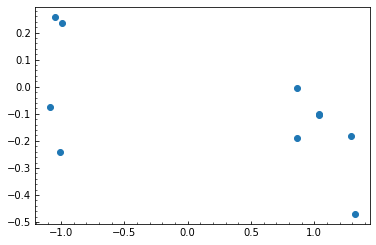

In [43]:
fig, ax = plt.subplots()
ax.plot(samples[:,0], samples[:,1], color='C0', marker='o', ls='')
#ax.plot(samples_history[:, 0, 0], samples_history[:, 0, 1], color='C1', alpha=0.75, ls='-')
plt.show()